## Step 1: Geocoding the provided data and calculating distances
### 1.1: Creating Functions
### 1.2: Executing the functions

In [1]:
# 1.1: CREATING FUNCTIONS


import pandas as pd
import geopandas as gpd
from geopy.geocoders import ArcGIS
from shapely.geometry import Point

# GEOCODER FUNCTION
def geo_coder(filename, crs_name):
    """Takes csv without header as input, return a projected geodataframe with possible geocodes.
    Args:
    filename: Str Input of CSV filename with ext containing addresses to geocode, WITHOUT a header
    crs_name: Int Input of desired projected coordinate system, use EPSG code.
    Raises:
    Error on empty csv or wrong crs given
    """
    try:
        # prepare a dataframe
        df = pd.read_csv(filename, header = None, names =['address_raw'], encoding='iso-8859-15')  #encoder value should be tweaked as it is for est lang
        split = df['address_raw'].str.split(',', 1, expand = True)
        data = df.assign(name = split[0], address = split[1]).drop(columns = ['address_raw'])
        data['latitude'] = ""
        data['longitude'] = ""
        # add ESRI geocoder, though its accuracy is totally off, works better with photon or google geocoder
        geolocator = ArcGIS(username = None, password = None, referer = None, token_lifetime = 60, scheme = 'https', timeout = 1, proxies = None)
        # assign coordinates to dataframe
        for index, row in data.iterrows():
            location = geolocator.geocode(row['address'],timeout = None)
            if location is not None:
                row['address'] = location.address
                row['latitude'] = location.latitude
                row['longitude'] = location.longitude
        # remove points which had empty lat/lon if any
        data = data[data.latitude != '']  
        # zip coordinates to convert df to gdf in pcs
        if len(data.index) != 0:
            geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
            gdf = gpd.GeoDataFrame(data, crs = 4326, geometry = geometry).to_crs(epsg = crs_name)
            return gdf
        else:
            print('Error: Empty geodataframe was returned, no addresses to geocode')
    except FileNotFoundError:
        print('Error: file {} was not found in script directory, check file name'.format(filename) )
    except:
        print('possible error/s 1: empty csv, 2: No comma seperated value found in csv column, 3: invalid crs given')

# DISTANCE CALCULATOR FUNCTION
def dist_cal(gdf):
    """Takes single geodataframe and calculate distance from its first row with all other rows.
    Args:
    gdf: geodataframe in projected coordinate system
    Exception:
    will return distances as 0 if geodataframe has gcs instead of pcs
    """
    try:
        distance = []
        for index, row in gdf.iterrows():
            distance.append ( gdf.iloc[0].geometry.distance(gdf.iloc[index].geometry) )
        gdf['dist'] = distance
        gdf['dis_km'] = (gdf['dist']/1000).round(2)
        gdf.drop(columns=['dist'], axis = 1, inplace = True)
        return gdf
    except:
        print('possible error/s 1: no geodataframe was given, or empty geometry col was given ')

In [2]:
# 1.2 EXECUTING THE FUNCTIONS


import timeit

# bench mark the time for running the whole program
start = timeit.default_timer()

# read the csv with relevant projected coordinate system
task_alpha = geo_coder('data.csv', 3301)     # calling function 1: geocoder
dist_cal(task_alpha)                         # calling function 2: dist_cal

end = timeit.default_timer()
total = end - start
print('Whole program takes', total, "seconds") 

Whole program takes 7.475613300000001 seconds


## Step 2: Visualising the results

In [3]:
import networkx as nx
from pyvis.network import Network

# LITTLE HOUSEKEEPING FOR VISULISATION
network = task_alpha[['name', 'dis_km']]
network = network.assign(source = network.iloc[0,0])
network = network.drop(index=0)
network.rename(columns = {'name' :'target', 'dis_km': 'weight'}, inplace = True)

# making a network out of the results
G = nx.from_pandas_edgelist(network, source = 'source', target = 'target', edge_attr = 'weight')

# visualising the network
net = Network(notebook=True, height="600px", width="100%", heading = 'Euclidean distance in kms from origin point')
net.from_nx(G)
net.set_options("""
var options = {
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      }
    },
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "nodes": {
    "color": {
      "border": "rgba(233,104,113,1)",
      "background": "rgba(151,194,252,1)",
      "highlight": {
        "border": "rgba(233,93,98,1)"
      }
    }
  },
  "physics": {
    "repulsion": {
      "springLength": 120
    },
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}
""")
#net.show_buttons(filter_=['physics'])
net.show('visulisation.html')

# Step 3: Web map and data publishing

In [4]:
# preparing df as required by arcgis api
from getpass import getpass

sdf = task_alpha.copy()
sdf = sdf.astype({'longitude': 'float', 'latitude': 'float'})
sdf.drop (columns = ['geometry'], inplace = True)
username = getpass()
password = getpass()

········
········


In [5]:
# create GIS object for arcgis online

from arcgis.gis import GIS
from pathlib import Path


mygis = GIS(username = username , password = password)

In [6]:
# publish to arcgis online

from arcgis.features import GeoAccessor, GeoSeriesAccessor

sdef = GeoAccessor.from_xy(sdf, 'longitude', 'latitude', sr = 4326)

sdef_item = sdf.spatial.to_featurelayer(title='AlphaGIS_clients', gis = mygis)

<Item title:"AlphaGIS_clients" type:Feature Layer Collection owner:MuhammadHamzaZubair>
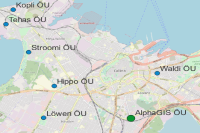

In [7]:
# display

from IPython.display import display

search_result = mygis.content.search("AlphaGIS_clients", "Feature Layer")
item = search_result[0]
item.update(thumbnail=r'C:\Users\humza\Desktop\geocoder\thumbnail.png')
item

# to access the published layer click 👇: 